# Introduction to the AGAMA (All-purpose GAlaxy Modelling Architecture) library for Galactic Dynamics

In [1]:
# import the relevant packages (agama for general galactic dynamics, pyfalcon for N-body simulations)
import agama 
import pyfalcon

import numpy as np # for numerical calculations
import matplotlib.pyplot as plt # for plotting
from matplotlib.gridspec import GridSpec # for advanced subplot layout
from matplotlib import rcParams

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

rcParams.update({
    "text.usetex": True,               # Use LaTeX for text
    "font.family": "serif",            # Use serif fonts
    "font.serif": ["Computer Modern"], # Default LaTeX font
    "axes.labelsize": 14,              # Axis label size
    "font.size": 13,                   # General font size
    "legend.fontsize": 12,             # Legend font size
    "xtick.labelsize": 12,             # X tick label size
    "ytick.labelsize": 12,             # Y tick label size
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}"  # Optional packages
})

# set units (mass = 1 M_sun, length = 1 kpc, velocity = 1 km/s)
agama.setUnits(mass=1, length=1, velocity=1)

### 1. Introduction

What is Agama?

Agama is a library that allows one to conduct, with relative ease, many foundational tasks in galaxy modelling. This includes:
 - Computation of gravitational forces, densities and potentials
 - Sampling from potentials and densities
 - Orbit integration and analysis
 - Conversion between different coordinate systems
 - Distribution functions (i.e. phase space probability distribution)
 - Constructing full galaxy models for later N-body usage
 
and much more. 

Therefore, Agama is an extremely useful tool for both simulating the structure of the Milky Way (or any other galaxy) and for analysing Galactic data from telescopes like _Gaia_. 

In this tutorial, we introduce many of the essential functions of Agama through the process of building galaxies of various complexity, and analysing their particles (which emulate stars and particles). These particles are obtained by sampling from the distribution function, density and/or potential of these galaxies. This simulated data takes the place of stellar data (i.e. actual stars), obtained from the _Gaia_ telescope. It is therefore straightforward to apply all of the techniques learned here to actual data.

Before jumping into the usage of Agama, we further contextualise its utility by describing the formation and structure of galaxies.

### 1.1 Galaxy formation

Galaxies form by what we refer to as _hierarchical assembly_. Namely, large galaxies exist as a result of the merging of smaller galaxies across cosmic time. 

Observationally, this implies the existence of a wide variety of galaxies of all shapes and sizes, which exhibit features indicative of collisions (often called mergers) and evidence of tidal interactions. This model of hierarchical assembly - sometimes given the more gruesome name of galactic cannibalism - is now widely accepted thanks to the plethora of evidence. This includes a variety of galactic structure in the universe, from large distant spiral galaxies (abundant with stellar sub-population and surrounded by tidal structure) like NGC 474 below, to small local _dwarf_ galaxies (exhibiting much more simple star formation histories).

More locally, in our own galaxy, evidence for hierarchical assembly is seen in the form of stellar streams. These are a specific type of tidal interactions whereby a satellite galaxy (or globular cluster) has its stars stretched out into a long arc. We do see these streams in more distant galaxies, but they are simply harder to detect because they are far away. In the Milky Way, there are arguably over 100 detected stellar streams.

<center>
<div>
<img src='figures/ngc474.png', width='700'>
</div>

The galaxy NGC 474, exhibiting clear tidal features such as shells and streams. 
</center>

### 1.2. Structure of the Milky Way

As mentioned previously, the unnumerable galaxies found throughout the universe come in a variety of sizes and structural compositions. Some are simple spherical dwarf galaxies, and some are complex spiral galaxies. Our home galaxy - The Milky Way - is a _barred_ spiral galaxy, broadly consisting of a small number of distinct stellar environments: 
- the stellar halo (a diffuse spherical outer region), 
- a rotationally supported disk, 
- the bulge (a central spherical dense region), 
- and an elongated rotating bar (which we will mostly ignore). 

Beyond this, the disk can be broken up into two more sub-regions called the thin and thick disk, whose co-evolution are not understood with concrete certainty. Evident by the naming convention, the thin disk has a smaller scale height than the thick disk and a narrower velocity distribution, in addition to unique chemical properties and a larger radial extent. Generally, the broad regions of the Milky Way are defined by the distinct chemical and kinematic properties of the stars that comprise them, but the inevitable overlap makes the defining of clear structural boundaries between them difficult. Understanding the way in which these distinct environments influence each other, and the way in which they chemo-kinematically evolve, is ongoing work. The role that _Gaia_ plays in understand this structure cannot be understated.

These stellar components are all embedded within a _dark matter halo_ which contributes the vast majority of the total mass of the Milky Way. While the dark matter halo was traditionally modelled to be approximately spherical, its exact shape is certainly more complicated. The hierachical formation of the Galaxy caused the stellar and dark halo to be lumpy and mishaped. While this makes the Milky Way harder to model, it also implies that the halo is littered with the fingerprints of past mergers and collisions. Large co-moving grouds and expansive stellar streams remain visible in the Galaxy for many billions of years. The goal of sieving through _Gaia_ data, therefore, is the to uncover these fingerprints by orbital integration and clever analysis.

<center>
<div>
<img src='figures/galaxy_cartoon.png', width='700'>
</div>

Illustration of the Milky Way with thin disk (pale orange ellipse), thick disk (faded purple ellipse), bulge (orange egg-yolk), stellar halo (cyan circle), dark matter halo (grey circle), globular clusters -- one with stellar stream -- (dark orange circles) and the Sagittarius Dwarf Galaxy with its stellar streams (yellow ellipse and stream).

</center>

### 1.3. Galactic Dynamics

This is a lightening fast overview of the key mathematical concepts needed to understand what Agama does and why it is useful. For a comprehensive overview, see <a href="https://galaxiesbook.org/">Jo Bovy's website</a> or <a href=https://www.tevza.org/home/course/AF2016/books/Galactic%20Dynamics,%20James%20Binney%20(2ed.,%20).pdf>Binney and Tremaine's textbook</a>.

### 1.3.1 Gravity and Potentials

The fundamental force governing all of galactic dynamics is, of course, gravity. Maybe surprisingly to some, in the context of merging galaxies, we need not bother with any Einsteinian formulations of gravity. Luckily, Newton will do! 

In Newtonian gravity, the gravitational acceleration $\bm{a}$ of a particle at position $\bm{x}$ is derived from a scalar gravitational potential $\Phi(\bm{x})$:

\begin{equation}
\bm{a} = \ddot{\bm{x}} = -\nabla \Phi(\bm{x}).
\end{equation}

All orbital calculations depend on evaluation $\Phi$ and its derivatives $\nabla \Phi$.

The gravitational potential is related the mass density $\rho(\bm{x})$ through Poisson's equation:

\begin{equation}
\nabla^2 \Phi(\bm{x}) = 4 \pi G \rho(\bm{x}).
\end{equation}

This equation links the mass of a galaxy to the forces experienced by the stars.

Agama can deal with a range of different density and potential models, using the `agama.Potential()` and `agama.Density()` functions.

### 1.3.2 Equations of motion

Given a potential $\Phi$, the orbits of particles (i.e. representing stars) are obtained by integrating Newton's second law, to obtain:

\begin{equation}
\frac{d\bm{x}}{dt} = \bm{v}, \qquad \frac{d\bm{v}}{dt} = -\nabla\Phi(\bm{x}).
\end{equation}

These six coupled first-order differential equations define a trajectory in _phase space_ $(\bm{x}, \bm{v})$. 

Agama solves these equations to conduct orbit integrations, using the `agama.orbit()` function.

### 1.3.2 Distribution functions

The state of a stellar system is described in six-dimensional phase space $(\bm{x}, \bm{v})$. However, rather than following individual stars, in galactic dynamics it is often conveient to describe systems statistically using a _distribution function_.

The distribution function $f(\bm{x}, \bm{y}, t)$ is defined such that,

\begin{equation}
f(\bm{x}, \bm{y}, t) \, d^3\bm{x} \, d^3\bm{v},
\end{equation}

is the mass (or number of stars) contained in a phase-space volume element. 

The spatial density is obtained by integrating the distribution function over velocity:

\begin{equation}
\rho(\bm{x}) = \int f(\bm{x}, \bm{y}, t) \, d^3\bm{v}.
\end{equation}

Agama supports a wide variety of distribution functions using the `agama.DistributionFunction()` function.

### 1.3.3 Collisionless systems

For a typical galaxy, it can be shown that the timescale on which a stars trajectory changes due to cumulative encounters (often denonated $t_{\rm relax}$) is related to the time in which this same star crosses the entire galaxy ($t_{\rm cross}$) by

\begin{equation}
    t_{\rm relax} = \frac{0.1 N}{ \ln N}t_{\rm cross},
\end{equation}

where $N$ is the number of stars in the galaxy, and 

\begin{equation}
    t_{\rm cross} = \frac{R_{\rm gal}}{v_{\rm star}}
\end{equation}

where $R_{\rm gal}$ is the radius of the galaxy and $v_{\rm star}$ is the typical velocity of a star in the galaxy (around 200 km/s in a MW-like galaxy). For sensible values of $N$ (around $\sim 10^{11}$ in a MW-like galaxy), we can see that $t_{\rm relax} \gg t_{\rm cross}$. This implies that the ensemble of stars in the galaxy behaves as a _collisionless system_.

By considering the conservation of the number of particles in the system, it can be shown that the particles in a collisionless system satisfy the _collisionless Boltzmann equation_ (CBE):

\begin{equation}
    \frac{\partial f(\bm{x}, \bm{v}, t)}{\partial t} + \frac{d\bm{x}}{dt}\frac{\partial f(\bm{x}, \bm{v}, t)}{\partial \bm{\dot{x}}} + \frac{d\bm{v}}{dt}\frac{df(\bm{x}, \bm{v}, t)}{d\bm{v}} = 0.
\end{equation}

This equation states that $f$ is a conserved quantity along orbits in phase space.

### 1.3.4 Integrals of motion and action-angle variables

Since $(\vec{x}, \vec{p})$ change as a function of time $t$, they are sometimes not helpful for understanding the orbits of the stars. Instead, we opt to characterize an orbit using its _integrals of motion_, which usually stay constant.

An integral of motion $I$ is a quantity which is conserved along an orbit, i.e.

\begin{equation}
\frac{dI}{dt} = 0.
\end{equation}

Crucially, any steady-state solution of the CBE can be written as a function of integrals of motion:

\begin{equation}
f = f(I_1, I_2, I_3).
\end{equation}

This is known as _Jean's theorem_, and it underpins most equilibrium galaxy models and is central to Agama's design. This result is powerful because it tells us that:

- we don't need to solve the CBE explicity
- any distribution function expressed in terms of integrals of motion is automatically an equilibrium system
- the complexity of a six-dimensional phase-space function can be described by a function of only three variables

Some of the most useful integrals of motion are _action-angle variables_.

### 2. The Milky Way's potential

To introduce some basic usage of Agama, we begin not by constructing our own potential, but my using a potential informed by data. Namely, we assume a static potential (i.e. constant in time), described in [Bovy 2014](https://arxiv.org/pdf/1412.3451.pdf).

In [Bovy 2014](https://arxiv.org/pdf/1412.3451.pdf), the Milky Way potential is estimated to made up of three main components: a dark matter halo, a spherical bulge, and a disk (see schematic below):

- **Dark Matter Halo**: described by a Navarro-Frenk-White (NFW) spherical density profile

 \begin{equation}
    \rho_\mathrm{halo}(r) = \left(8.49 \times 10^6 \, \frac{\mathrm{M_\odot}}{\mathrm{kpc^3}}\right) 
    \left(\frac{r}{16 \, \mathrm{kpc}}\right)^{-1} 
    \left(1 + \frac{r}{16 \, \mathrm{kpc}}\right)^{-2}
 \end{equation}

 where $r$ is the spherical radius.

- **Galactic Bulge**: described by a power-law density with an exponential cut-off

 \begin{equation}
    \rho_\mathrm{bulge}(r) = \left(2.23 \times 10^8 \, \frac{\mathrm{M_\odot}}{\mathrm{kpc^3}}\right) 
    \,\left(\frac{r}{1 \, \mathrm{kpc}}\right)^{-1.8}\,\exp\left[-\left(\frac{r}{1.9 \, \mathrm{kpc}}\right)^2\right]
 \end{equation}

 where $\rho_1$ is the central density, $r_1$ is the scale radius, and $r_c$ is the cut-off radius.
 The potential of the bulge may be calculated from the enclosed mass $M_\mathrm{enc}(r)$

 \begin{equation}
    \Phi_\mathrm{spherioid}(r) = - \frac{G M_\mathrm{enc}(r)}{r}, 
    \quad \mathrm{where} \quad 
    M_\mathrm{enc}(r) = \int_0^r \rho(\mathrm{\tilde{r}}) \, 4\pi \tilde{r}^2 \, d\tilde{r}
 \end{equation}


- **Disk**: described by the Miyamoto-Nagai potential model ([Miyamoto & Nagai 1975](https://ui.adsabs.harvard.edu/abs/1975PASJ...27..533M/abstract)):

 \begin{equation}
    \Phi_\mathrm{disk}(R, z) = - \frac{GM}{\sqrt{R^2 + \left(\sqrt{z^2 + b^2} + a\right)^2}}
 \end{equation}

 where $R$ is the cylindrical radius, $z$ is the height, $M=6.82 \times 10^{10} \, M_\odot$ is the total mass of the disk, $b=0.28 \, \mathrm{kpc}$ is the scale height, and $a = 3 \, \mathrm{kpc}$ is the scale length.

In [3]:
# Read in the potential of the Milky Way
potential = agama.Potential(file='potentials/MWPotential2014.ini')

We may also plot the rotational velocity $v_\mathrm{rot}(R)$ at a given height $z$ ($R$ is the cylindrical radius).
The rotational velocity is defined as:

\begin{equation}
    v_\mathrm{rot}^2(R)  = \frac{\partial \Phi(R, z)}{\partial R} R
\end{equation}

The plot of circular velocity against radius is sometimes called the _rotation curve_ of a galaxy. Rotation curves are a historical diagnostic tool to learn about the properties of the galaxy in question.

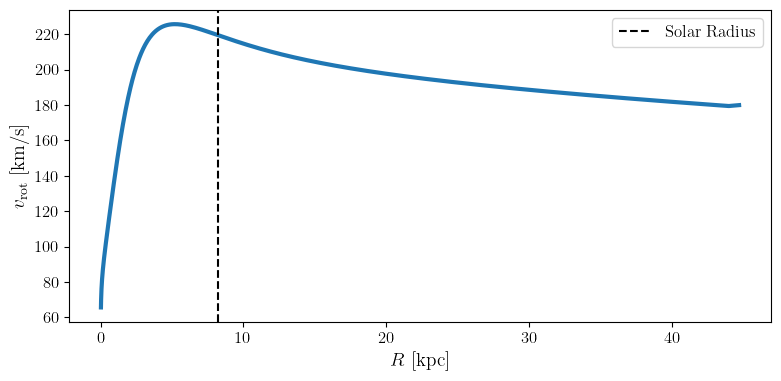

In [4]:
# Plot the rotation curve given by this potential at z=0
fig, ax = plt.subplots(1, figsize=(8, 4))

r_max = 50
X = np.logspace(-2, 1.5, 500)
Y = np.logspace(-2, 1.5, 500)
Z = np.zeros_like(X) 
R = np.sqrt(X**2 + Y**2)

# Calculate the rotation velocity defined by
# v^2 = (dPhi / dR) * R
simulated_pos = np.stack([X, Y, Z], axis=1)    
vrot = np.sqrt(np.gradient(potential.potential(simulated_pos), R) * R)
ax.plot(R, vrot, lw=3)
ax.axvline(8.2, color='k', ls='--', label='Solar Radius')

ax.set_ylabel(r'$v_\mathrm{rot} \; [\mathrm{km} / \mathrm{s}]$')
ax.set_xlabel('$R$ [kpc]')
ax.legend()

fig.tight_layout()

### 3. Orbit integration

Orbit integration requires knowledge of the potential $\Phi$ (or equivalently the density $\rho$) of the Milky Way.

With the `MWPotential2014` potential, we may now perform orbit integration.

In this example, we will use Agama to integrate the orbit of the Sun around the Galactic center. To do this, we need the initial positions and velocities of the Sun. We set these to:

\begin{align}
    (x, y, z) &= (8.2, \; 0, \; 0) \, \mathrm{kpc} \\
    (v_x, v_y, v_z) &= (20.3801, \; 224.7092, \; 3.8954) \, \mathrm{km/s}
\end{align}

Adjusting these initial conditions will change the orbit. Give it a go.

In [5]:
# Initial position and velocities of the Sun
posvel = np.array([[8.2, 0, 0, 20.3801, 224.7092, 3.8954]])

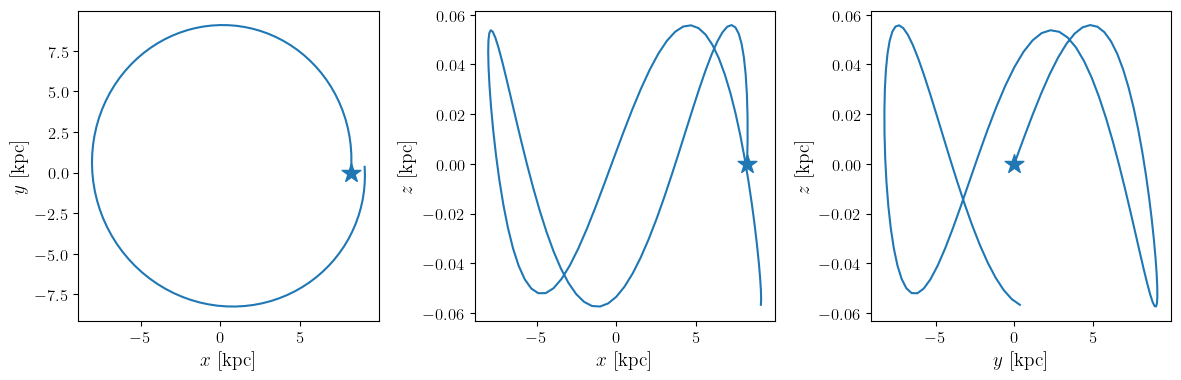

In [6]:
# Integrate and plot the orbit for 250 Million years
times, orbit = agama.orbit(
    ic=posvel, potential=potential, time=0.25, trajsize=100)[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(orbit[:, 0], orbit[:, 1])
axes[1].plot(orbit[:, 0], orbit[:, 2])
axes[2].plot(orbit[:, 1], orbit[:, 2])

axes[0].scatter(posvel[0, 0], posvel[0, 1], marker="*", s=200)
axes[1].scatter(posvel[0, 0], posvel[0, 2], marker="*", s=200)
axes[2].scatter(posvel[0, 1], posvel[0, 2], marker="*", s=200)

axes[0].set_xlabel(r'$x$ [kpc]')
axes[1].set_xlabel(r'$x$ [kpc]')
axes[2].set_xlabel(r'$y$ [kpc]')
axes[0].set_ylabel(r'$y$ [kpc]')
axes[1].set_ylabel(r'$z$ [kpc]')
axes[2].set_ylabel(r'$z$ [kpc]')

fig.tight_layout()

In [33]:
# Example: replace with your orbit arrays x[t], y[t]

x = orbit[:500,0]
y = orbit[:500,1]

fig, ax = plt.subplots()
ax.set_aspect("equal", "box")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

pt, = ax.plot([], [], "*", c='blue', ms=10)
trail, = ax.plot([], [], "-", lw=1, c='blue')

def init():
    pt.set_data([], [])
    trail.set_data([], [])
    return pt, trail

def update(i):
    pt.set_data([x[i]], [y[i]])
    trail.set_data(x[:i+1], y[:i+1])
    return pt, trail

ani = FuncAnimation(fig, update, frames=len(x), init_func=init, interval=20, blit=True)
HTML(ani.to_jshtml())  # inline JS animation (recommended in notebooks)

plt.show()


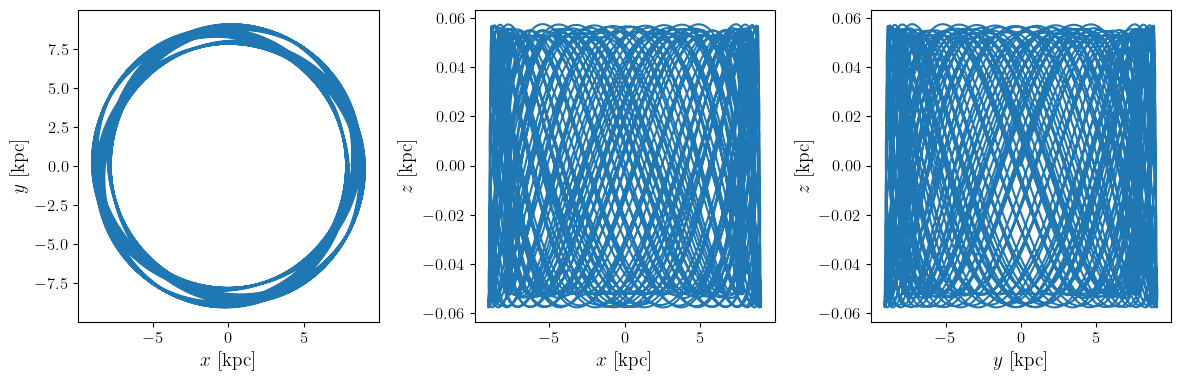

In [7]:
# Integrate and plotthe orbit for 10 Billion years
times, orbit = agama.orbit(
    ic=posvel, potential=potential, time=10, trajsize=10000)[0]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(orbit[:, 0], orbit[:, 1])
axes[1].plot(orbit[:, 0], orbit[:, 2])
axes[2].plot(orbit[:, 1], orbit[:, 2])

axes[0].set_xlabel(r'$x$ [kpc]')
axes[1].set_xlabel(r'$x$ [kpc]')
axes[2].set_xlabel(r'$y$ [kpc]')
axes[0].set_ylabel(r'$y$ [kpc]')
axes[1].set_ylabel(r'$z$ [kpc]')
axes[2].set_ylabel(r'$z$ [kpc]')

fig.tight_layout()

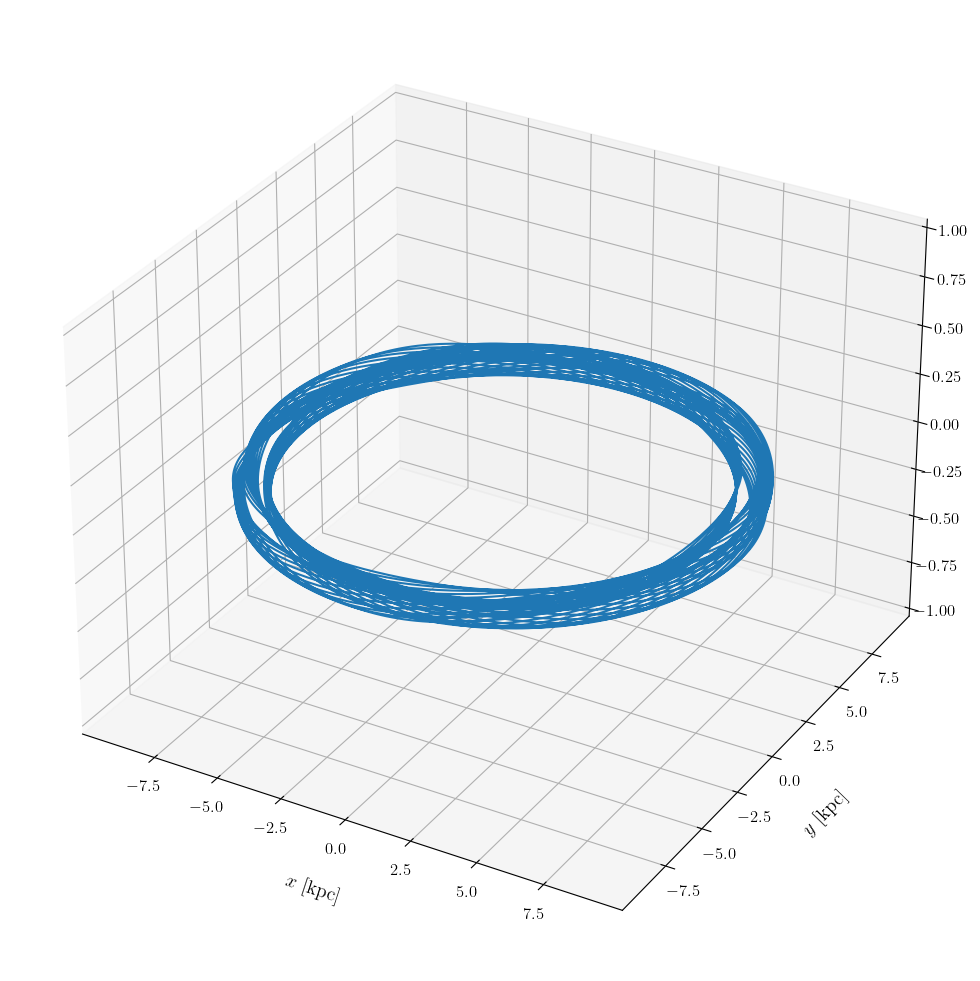

In [8]:
# Plot 3D orbit
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.plot3D(orbit[:, 0], orbit[:, 1], orbit[:, 2])
ax.set_xlabel(r'$x$ [kpc]', labelpad=15)
ax.set_ylabel(r'$y$ [kpc]', labelpad=15)
ax.set_zlabel(r'$z$ [kpc]', labelpad=15)
ax.set_zlim3d(-1, 1)

fig.tight_layout()

### 4. Galaxy modelling

### 4.1 Simple single-component galaxy

In [9]:
# Can initialise a potential object using agama.Potential()

# Dark matter halo potential
pot_dm_halo = agama.Potential(type='Plummer', mass=1e12, scaleRadius=10) # Simple Plummer sphere as an example halo

# We could equivalently specify a density using agama.Density()
# In this case, the density is implicit. We have never specified it.

# Distribution function ('QuasiSpherical' uses Eddington inversion formula)
df_host = agama.DistributionFunction(potential=pot_dm_halo, type='QuasiSpherical')

# Create a ''galaxy model'' object to work with
galaxy_model = agama.GalaxyModel(potential=pot_dm_halo, df=df_host)

# Sample the distribution function
N = int(1e5)
particles, mass = galaxy_model.sample(N) #outputs the (N,6) particles positions and velocity array AND the (N,) masses of each particle

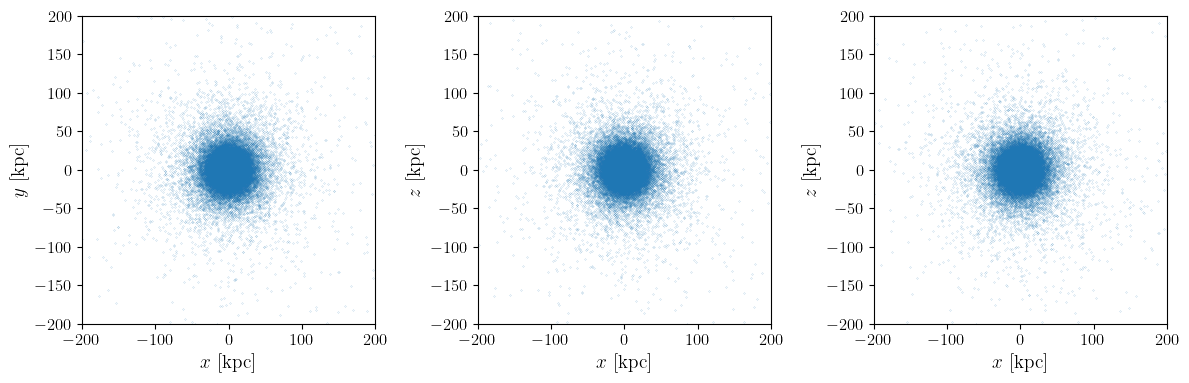

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

plt.subplots_adjust(wspace=0.35)  # Increase the width between the subplots

for axis in (ax1, ax2, ax3):
    axis.set_rasterization_zorder(10)
    axis.set_xlim(-200,200) # changes the limits of the figure to (-200,200) for the x-axis
    axis.set_ylim(-200,200) # and for the y-axis

ax1.scatter(particles[:,0], particles[:,1], s=0.01) # x-y
ax2.scatter(particles[:,1], particles[:,2], s=0.01) # y-z
ax3.scatter(particles[:,0], particles[:,2], s=0.01) # x-z

ax1.set_xlabel(r'$x$ [kpc]')
ax2.set_xlabel(r'$x$ [kpc]')
ax3.set_xlabel(r'$x$ [kpc]')
ax1.set_ylabel(r'$y$ [kpc]')
ax2.set_ylabel(r'$z$ [kpc]')
ax3.set_ylabel(r'$z$ [kpc]')

plt.show()

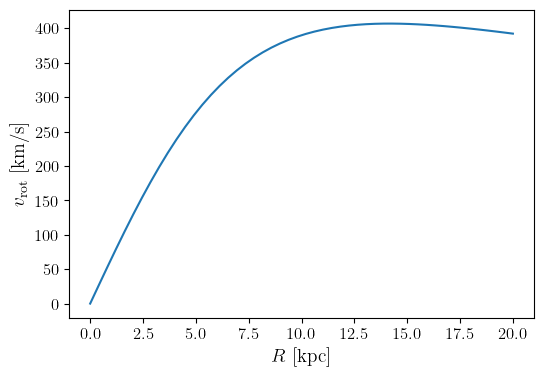

In [50]:
# We can plot the rotiation curve of this Plummer sphere:

r = np.linspace(0,20)
points = np.column_stack((r, r*0, r*0)) # a N × 3 array


fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.plot(r, np.sqrt(-r*pot_dm_halo.force(points)[:,0]))

ax.set_xlabel(r'$R$ [kpc]')
ax.set_ylabel(r'$v_\mathrm{rot} \; [\mathrm{km} / \mathrm{s}]$')

plt.show()

In [12]:
# We can now integrate the orbits of these particles to see their orbital evolution

N_traj = 1000 # number of out-puts
time_initial = 0.0 # initial time (Gyrs)
time_final   = 10.0 # final time (Gyrs)

orbit_list = agama.orbit(potential=pot_dm_halo, ic=particles, time=time_final, timestart=time_initial, trajsize=N_traj)

100000 orbits complete (3243 orbits/s)                     


 Now we have the time evolution of all the particles!

In [48]:
# Agama has slightly annoying shapes for the outputs

posvels = orbit_list[:,1] # shape is (N), where each element is an array of shape (N_traj,6)
times   = orbit_list[:,0]

# To get the time array, just take times[0]
time = times[0] # just an array of length N_traj from time_initial to time_final

# For particle i, you get it's 6d position-velocity array (across all 1000 timesteps) with posvels[i]
example_particle = posvels[-1]

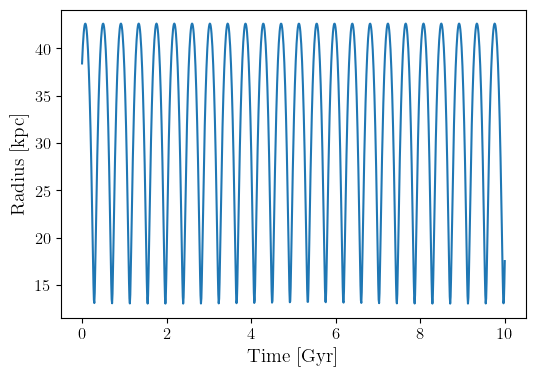

In [49]:
# radius of particle, r=(x^2 + y^2 + z^2)^(1/2) over time
radius = np.sum(example_particle[:, 0:3]**2, axis=1)**(0.5)

fig, ax = plt.subplots(1,1, figsize=(6, 4))

# plot radius against time
ax.plot(time, radius)

ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('Radius [kpc]')

plt.show()

### 4.3 Multi-component galaxy model

In [15]:
# Dark matter halo potential
pot_halo = agama.Potential(type='Spheroid', mass=1e12, scaleRadius=15, gamma=1, beta=3, outerCutoffradius=240)
pot_disk = agama.Potential(type='Disk', mass=6e10, scaleRadius=3.0, scaleHeight=-0.5)
pot_both = agama.Potential(pot_halo, pot_disk)

# Halo DF
den_halo = agama.Density(pot_halo)  # explicity density statement
df_halo  = agama.DistributionFunction(type='Quasispherical', potential=pot_both)

# Disk DF
df_disk = agama.DistributionFunction(type='QuasiIsothermal', potential=pot_both, mass=6e10, Rdisk=3.0,
                                     sigmar0=150, Rsigmar=6, Hdisk=0.5)

# number of particles the disk
N_disk = 5000
N_halo = 10000

# Sample disk stars using the disk distribution function in the entire potential
disk_p, disk_m = agama.GalaxyModel(potential=pot_both, df=df_disk).sample(N_disk)

# Sample halo particles using the disk distribution function in the entire potential
halo_p, halo_m = agama.GalaxyModel(potential=pot_both, df=df_halo).sample(N_halo)

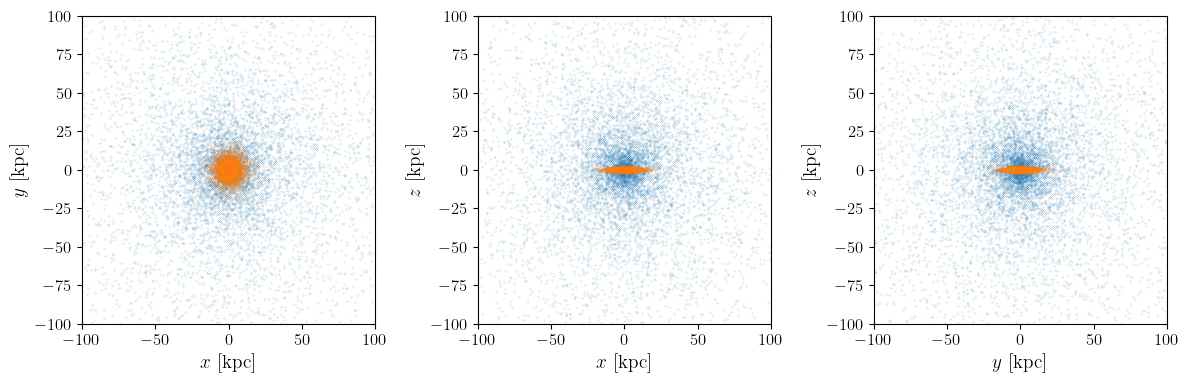

In [43]:
# Visualising the two different components

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for axis in (ax1, ax2, ax3):
    axis.set_rasterization_zorder(10)
    axis.set_xlim(-100,100)
    axis.set_ylim(-100,100)

plt.subplots_adjust(wspace=0.35)

ax1.scatter(halo_p[:,0], halo_p[:,1], s=0.01)
ax2.scatter(halo_p[:,1], halo_p[:,2], s=0.01)
ax3.scatter(halo_p[:,0], halo_p[:,2], s=0.01)

ax1.scatter(disk_p[:,0], disk_p[:,1], s=0.01)
ax2.scatter(disk_p[:,1], disk_p[:,2], s=0.01)
ax3.scatter(disk_p[:,0], disk_p[:,2], s=0.01)

ax1.set_xlabel('$x$ [kpc]')
ax2.set_xlabel('$x$ [kpc]')
ax3.set_xlabel('$y$ [kpc]')

ax1.set_ylabel('$y$ [kpc]')
ax2.set_ylabel('$z$ [kpc]')
ax3.set_ylabel('$z$ [kpc]')


plt.show()

### 5. Self-consistent modelling

When working with a galaxy of many components, we want to make sure that everything is self-consistent i.e. that the Poisson equation would actually give us the correct potential from the density even after we separately define everything as distinct components (we don't want any weird discontinuities). This can be done by providing sensible initial guesses and iterating to a well-behaved potential

As well as providing parameters for the potential components, the density and the distribution function, we now need to specific the grid over which the self consistent model explores. This is well explained in the reference documentation.

Much of the below is adapted from examples in the Agama download files.

In [17]:
# Easiest to specify parameters as dictionary entries (descriptions of what these are can be found
# in the reference documentation)

config = {
    "Potential halo": {
        "Type": "Spheroid",
        "mass": 0.8e12,                  # total mass: 0.8e12 Msun
        "axisRatioZ": 1.0,               # flattening (z/R)
        "gamma": 1,                      # inner power-law slope
        "beta": 3,                       # outer power-law slope
        "scaleRadius": 16.0,             # break radius
        "outerCutoffRadius": 240.0,      # exponential cutoff radius
    },

    "Potential bulge": {
        "Type": "Sersic",
        "mass": 1e10,                   # total mass: 1e10 Msun
        "scaleRadius": 0.8,
        "sersicIndex": 2.0,
        "axisRatioZ": 1.0,               # flattening (z/R)
    },

    "Potential disk": {
        "Type": "Disk",
        "SurfaceDensity": 4700,          # Σ0 = Mtotal / (2πRdisk²); mass ≈ 5e10 Msun = 2.15e5
        "ScaleRadius": 2.7,              # exponential scale radius (Rdisk)
        "ScaleHeight": -0.5,             # negative = isothermal (sech²)
    },

    "DF disk": {
        "type": "QuasiIsothermal",
        "Sigma0": 1e9,                  # surface density normalization (R=0)
        "Rdisk": 2.5,                    # exponential scale radius
        "Hdisk": 0.50,                   # scale height in sech² profile
        "sigmar0": 160.0,                # σ_R(R=0)
        "sigmamin": 20.0,                # lower limit for velocity dispersion
        "Rsigmar": 8.0,                  # σ_R scale length
    },

    "SelfConsistentModel halo": {
        "rminSph": 0.05,
        "rmaxSph": 400.0,
        "sizeRadialSph": 30,
        "lmaxAngularSph": 6,
    },

    "SelfConsistentModel bulge": {
        "rminSph": 0.05,
        "rmaxSph": 10.0,
        "sizeRadialSph": 25,
        "lmaxAngularSph": 6,
    },

    "SelfConsistentModel disk": {
        "RminCyl": 0.05,
        "RmaxCyl": 25.0,
        "sizeRadialCyl": 20,
        "zminCyl": 0.05,
        "zmaxCyl": 5.0,
        "sizeVerticalCyl": 15,
    },

    "SelfConsistentModel": {
        "rminSph": 0.05,
        "rmaxSph": 500.0,
        "sizeRadialSph": 40,
        "lmaxAngularSph": 6,
        "RminCyl": 0.05,
        "RmaxCyl": 40.0,
        "sizeRadialCyl": 25,
        "zminCyl": 0.05,
        "zmaxCyl": 20.0,
        "sizeVerticalCyl": 25,
        "useActionInterpolation": False,  # speed vs. accuracy tradeoff
    },
}

param_pot_halo  = config['Potential halo']
param_pot_bulge = config['Potential bulge'] 
param_pot_disk  = config['Potential disk']

param_df_disk   = config['DF disk']

param_SCM_halo  = config["SelfConsistentModel halo"]
param_SCM_bulge = config["SelfConsistentModel bulge"]
param_SCM_disk  = config["SelfConsistentModel disk"]
param_SCM       = config["SelfConsistentModel"]

In [18]:
# initialize the SelfConsistentModel object (only the potential expansion parameters)
model = agama.SelfConsistentModel(**param_SCM)

# create initial density profiles of all components
densityDisk  = agama.Density(**param_pot_disk)
densityBulge = agama.Density(**param_pot_bulge)
densityHalo  = agama.Density(**param_pot_halo)

# The SCM has ''component'' objects
# add components to SCM - at first, all of them are static density profiles
model.components.append(agama.Component(density=densityDisk,  disklike=True))
model.components.append(agama.Component(density=densityBulge, disklike=False))
model.components.append(agama.Component(density=densityHalo,  disklike=False))

In [19]:
# compute the initial potential
model.iterate()

Updating potential...

done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Computing density for component 2...done
Updating potential...done
Updating action finder...done


In [20]:
# construct the DF of the disk component, using the initial (non-spherical) potential
dfDisk  = agama.DistributionFunction(potential=model.potential, **param_df_disk)

# initialize the DFs of spheroidal components using the Eddington inversion formula
# for their respective density profiles in the initial potential
dfBulge = agama.DistributionFunction(type='QuasiSpherical', potential=model.potential, density=densityBulge)
dfHalo  = agama.DistributionFunction(type='QuasiSpherical', potential=model.potential, density=densityHalo)

In [21]:
# replace the initially static SCM components with the DF-based ones
model.components[0] = agama.Component(df=dfDisk,  disklike=True,  **param_SCM_disk)
model.components[1] = agama.Component(df=dfBulge, disklike=False, **param_SCM_bulge)
model.components[2] = agama.Component(df=dfHalo,  disklike=False, **param_SCM_halo)

# do a few more iterations to obtain the self-consistent density profile for both disks
for iteration in range(1,5):
    model.iterate()

# export model to an N-body snapshot
format = 'nemo'  # one could also use 'nemo' or 'gadget' here
Ndisk = 6670
Nbulge= 1330
Nhalo = 80000

diskp,diskm = agama.GalaxyModel(potential=model.potential, df=dfDisk,  af=model.af).sample(Ndisk)
bulgp,bulgm = agama.GalaxyModel(potential=model.potential, df=dfBulge, af=model.af).sample(Nbulge)
halop,halom = agama.GalaxyModel(potential=model.potential, df=dfHalo,  af=model.af).sample(Nhalo)

Computing density for component 0...

done
Computing density for component 1...done
Computing density for component 2...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Computing density for component 2...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Computing density for component 2...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Computing density for component 2...done
Updating potential...done
Updating action finder...done


We now have a self consistent potential, density, and distribution function for the galaxy!

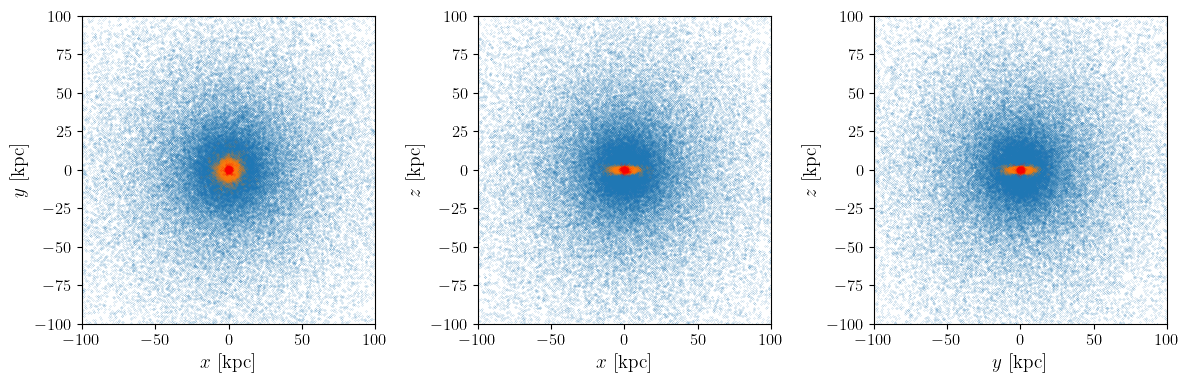

In [46]:
# Visualising the two different components

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for axis in (ax1, ax2, ax3):
    axis.set_rasterization_zorder(10)
    axis.set_xlim(-100,100)
    axis.set_ylim(-100,100)
    axis.set(xlim=(-100, 100), ylim=(-100, 100))

ax1.set_xlabel('$x$ [kpc]')
ax2.set_xlabel('$x$ [kpc]')
ax3.set_xlabel('$y$ [kpc]')
ax1.set_ylabel('$y$ [kpc]')
ax2.set_ylabel('$z$ [kpc]')
ax3.set_ylabel('$z$ [kpc]')
plt.subplots_adjust(wspace=0.35)

ax1.scatter(halop[:,0], halop[:,1], s=0.01)
ax2.scatter(halop[:,1], halop[:,2], s=0.01)
ax3.scatter(halop[:,0], halop[:,2], s=0.01)

ax1.scatter(diskp[:,0], diskp[:,1], s=0.01)
ax2.scatter(diskp[:,1], diskp[:,2], s=0.01)
ax3.scatter(diskp[:,0], diskp[:,2], s=0.01)

ax1.scatter(bulgp[:,0], bulgp[:,1], s=0.01, c='r')
ax2.scatter(bulgp[:,1], bulgp[:,2], s=0.01, c='r')
ax3.scatter(bulgp[:,0], bulgp[:,2], s=0.01, c='r')

plt.show()

In [23]:
# The self connsistent model then be used with
pot_scm = model.potential

### 6. Pyfalcon (N-body simulations and Agama)

Having now explored the use of Agama in a static Milky Way potential, we look to increase the realisim by introduction a population of stars that enter the Milky Way from an external merging galaxy, thus simulating the process of hierarchical assembly.

The satellite galaxy consists of self-gravitating N body particles, but the host does not.

In [24]:
# Let's just use the simple Plummer from before
pot_host = pot_dm_halo 

# The satellite galaxy has some simple potential
pot_sat = agama.Potential(type='Spheroid', gamma=1, beta=4, scaleRadius=1.0, outercutoffradius=3.0, mass=1e10)

# And some Eddington-Inversion formula produced distribution function
df_sat = agama.DistributionFunction(type='quasispherical', potential=pot_sat)

# Sample 
N = 5*10**4 # number of particles
xv, mass = agama.GalaxyModel(pot_sat, df_sat).sample(N) # sample the particles
pos = xv[:,0:3] # positions
vel = xv[:,3:6] # velocities

# Since falcON uses natural units (G=1), we multiply particle masses by G to get the correct units
Gmass = agama.G * mass

In [25]:
# Place the satellite at the apocenter of an orbit with eccentricity, e = 0.7
R0 = 50.0 # initial distance from host center
Z0 = R0*np.arctan(15/180) # small inclination
Vcirc = (-R0*pot_host.force(R0,0,0)[0])**0.5 # circular velocity at R0
V0 = 0.7*Vcirc # initial velocity magnitude

In [26]:
# Set the initial displacement of the satellite
cpos = np.array([-R0, 0.0, 0.0]) # position offset
cvel = np.array([V0, V0/4, 0.0]) # velocity offset
 
pos += cpos 
vel += cvel

In [27]:
#Set up N-body properties
eps = 0.05 # softening length
tau = 2**-8 # timestep
time = 0.0 # current time
tend = 5.0 # final time
tplot = 2**-4 # frequency of plotting

# Initialise the accelerations and potential (where pyfalcon really comes in ...)
acc, pot = pyfalcon.gravity(pos, Gmass, eps)
acc += pot_host.force(pos)

In [28]:
# Define the integration functions (kick-drift-kick)

def leapfrog_step():
    '''Perform one step of a basic kick-drift-kick leapfrog method'''
    global pos,vel,acc,pot,time,cpos,cvel  # global variables
    # kick for half-step, using accelerations computed at the end of the previous step
    vel += acc * (tau/2)
    # drift for full step
    pos += vel * tau
    # recompute accelerations from self-gravity of the satellite
    acc, pot = pyfalcon.gravity(pos, Gmass, eps)
    # add accelerations from the host galaxy
    acc += pot_host.force(pos)
    # kick again for half-step
    vel += acc * (tau/2)
    time+= tau

def update_centre_and_bound_mass():
    # update the location of the satellite centre, using only particles within Rmax from the centre
    # (i.e. ignoring the already stripped debris)
    global cpos, cvel
    cpos += tau * cvel  # linearly extrapolate from the previous timestep
    Rmax = 5.0
    use  = np.sum((pos-cpos)**2, axis=1) < Rmax**2
    # iteratively refine the selection, retaining only bound particles (which have
    # negative total energy in the satellite-centered frame using its own potential only)
    prevcpos = cpos
    for i in range(10):
        cpos = np.median(pos[use], axis=0)
        cvel = np.median(vel[use], axis=0)
        #print np.sum(use), cpos, cvel
        use = (pot + 0.5 * np.sum((vel-cvel)**2, axis=1) < 0)
        if np.sum(use)<=1 or all(cpos==prevcpos): break
        prevcpos = cpos
    bound[:] = use

In [29]:
times = []
pos_list = []
vel_list = []
bound = np.ones(len(pos))
indplot = 0

while time <= tend:
    times.append(time)
    print("time=%6.4f boundfrac=%6.4f" % (time, np.mean(bound)))
    pos_list.append(np.array(pos))
    vel_list.append(np.array(vel))
    leapfrog_step()
    update_centre_and_bound_mass()

time=0.0000 boundfrac=1.0000
time=0.0039 boundfrac=0.9887
time=0.0078 boundfrac=0.9896
time=0.0117 boundfrac=0.9898
time=0.0156 boundfrac=0.9898
time=0.0195 boundfrac=0.9898
time=0.0234 boundfrac=0.9898
time=0.0273 boundfrac=0.9898
time=0.0312 boundfrac=0.9899
time=0.0352 boundfrac=0.9899
time=0.0391 boundfrac=0.9898
time=0.0430 boundfrac=0.9897
time=0.0469 boundfrac=0.9896
time=0.0508 boundfrac=0.9896
time=0.0547 boundfrac=0.9896
time=0.0586 boundfrac=0.9894
time=0.0625 boundfrac=0.9893
time=0.0664 boundfrac=0.9891
time=0.0703 boundfrac=0.9892
time=0.0742 boundfrac=0.9888
time=0.0781 boundfrac=0.9887
time=0.0820 boundfrac=0.9882
time=0.0859 boundfrac=0.9878
time=0.0898 boundfrac=0.9872
time=0.0938 boundfrac=0.9863
time=0.0977 boundfrac=0.9851
time=0.1016 boundfrac=0.9828
time=0.1055 boundfrac=0.9801
time=0.1094 boundfrac=0.9756
time=0.1133 boundfrac=0.9692
time=0.1172 boundfrac=0.9633
time=0.1211 boundfrac=0.9563
time=0.1250 boundfrac=0.9465
time=0.1289 boundfrac=0.9336
time=0.1328 bo

Now we plot the initial and final snapshot of the external galaxies particles. The host galaxy is invisible in these figures.

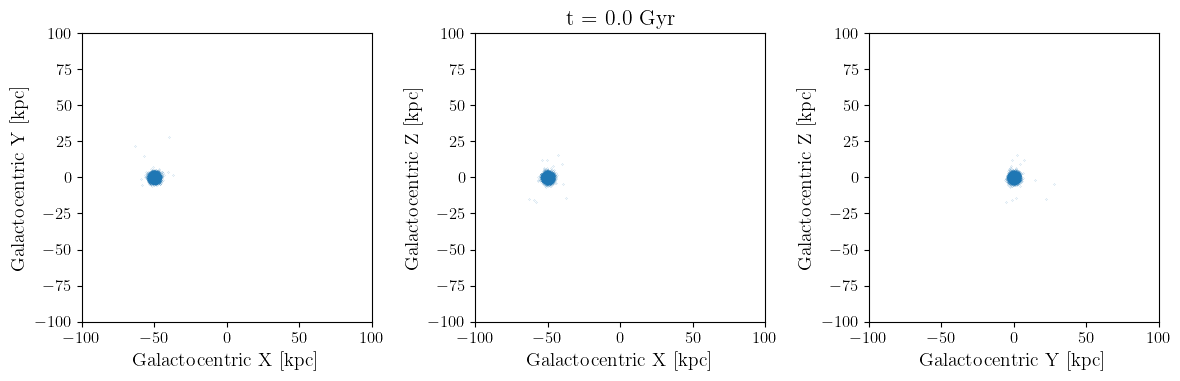

In [30]:
step = 0
x, y, z = pos_list[step].T  # unpack directly

# coordinate pairs and labels
coords = [(x, y, 'X', 'Y'),
          (x, z, 'X', 'Z'),
          (y, z, 'Y', 'Z')]

fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, figure=fig)

for i, (a, b, la, lb) in enumerate(coords):
    ax = fig.add_subplot(gs[0, i])
    ax.scatter(a, b, s=0.01)
    ax.set(xlim=(-100, 100), ylim=(-100, 100),
           xlabel=f'Galactocentric {la} [kpc]',
           ylabel=f'Galactocentric {lb} [kpc]')
    if i == 1:
        ax.set_title('t = 0.0 Gyr')

plt.tight_layout()
plt.show()


In [31]:
len(pos_list)

1281

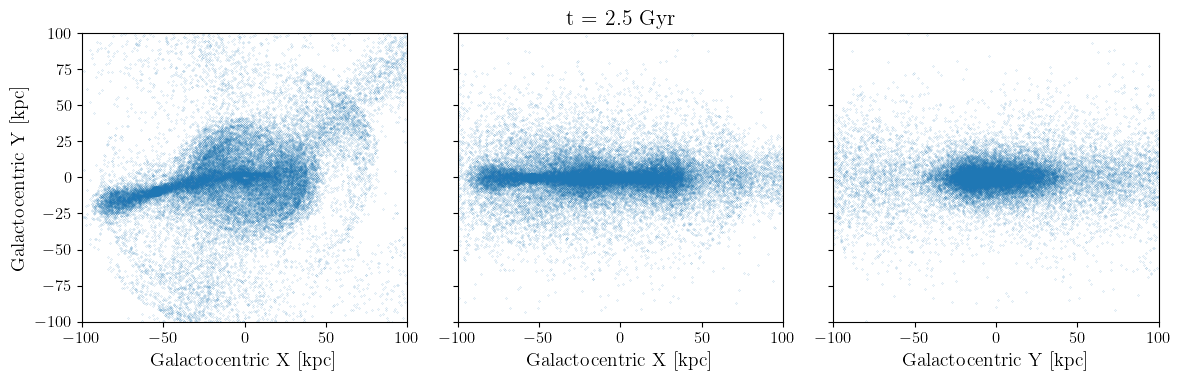

In [62]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

step = 640
x, y, z = pos_list[step].T  # unpack directly

# coordinate pairs and labels
coords = [(x, y, 'X', 'Y'),
          (x, z, 'X', 'Z'),
          (y, z, 'Y', 'Z')]

fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, figure=fig)

for i, (a, b, la, lb) in enumerate(coords):
    ax = fig.add_subplot(gs[0, i])
    ax.scatter(a, b, s=0.01)
    ax.set(xlim=(-100, 100), ylim=(-100, 100),
           xlabel=f'Galactocentric {la} [kpc]',
           ylabel=f'Galactocentric {lb} [kpc]')
    if i == 1:
        ax.set_title('t = 2.5 Gyr')
    ax.label_outer()

plt.tight_layout()
plt.show()


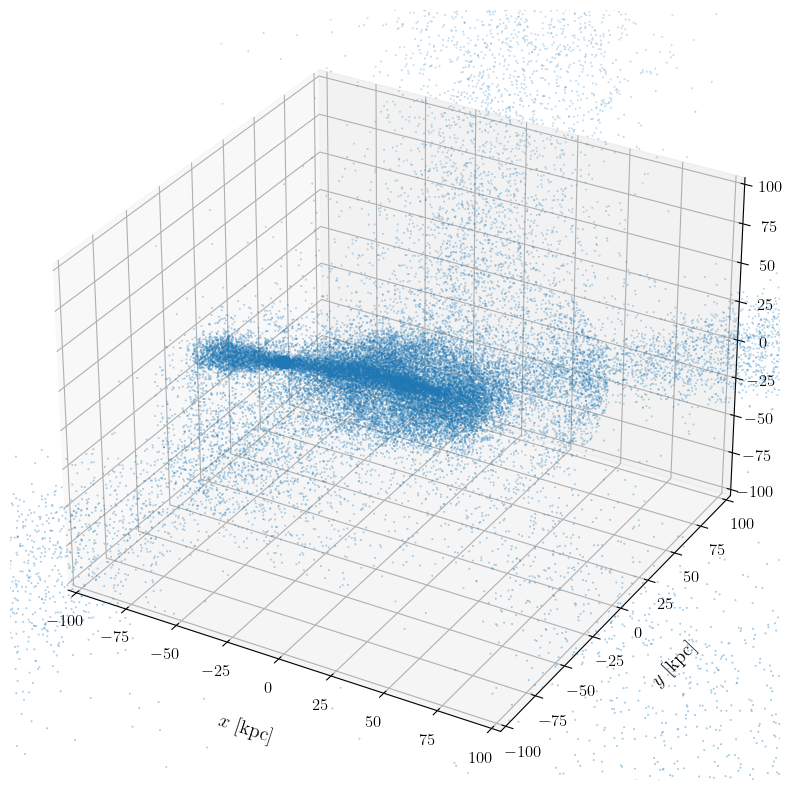

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z, s=0.1)
ax.set_xlabel(r'$x$ [kpc]', labelpad=15)
ax.set_ylabel(r'$y$ [kpc]', labelpad=15)
ax.set_zlabel(r'$z$ [kpc]', labelpad=15)
ax.set_xlim3d(-100, 100)
ax.set_ylim3d(-100, 100)
ax.set_zlim3d(-100, 100)

plt.show()

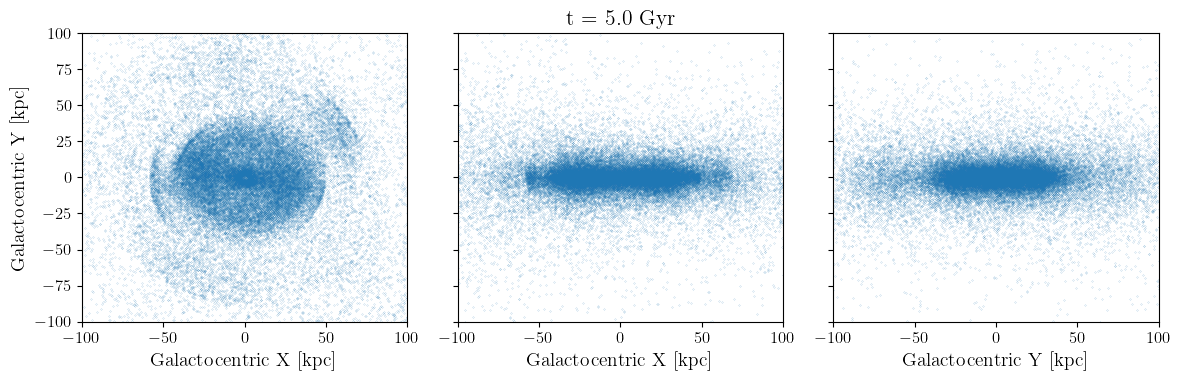

In [64]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

step = -1
x, y, z = pos_list[step].T  # unpack directly

# coordinate pairs and labels
coords = [(x, y, 'X', 'Y'),
          (x, z, 'X', 'Z'),
          (y, z, 'Y', 'Z')]

fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, figure=fig)

for i, (a, b, la, lb) in enumerate(coords):
    ax = fig.add_subplot(gs[0, i])
    ax.scatter(a, b, s=0.01)
    ax.set(xlim=(-100, 100), ylim=(-100, 100),
           xlabel=f'Galactocentric {la} [kpc]',
           ylabel=f'Galactocentric {lb} [kpc]')
    if i == 1:
        ax.set_title('t = 5.0 Gyr')
    ax.label_outer()

plt.tight_layout()
plt.show()


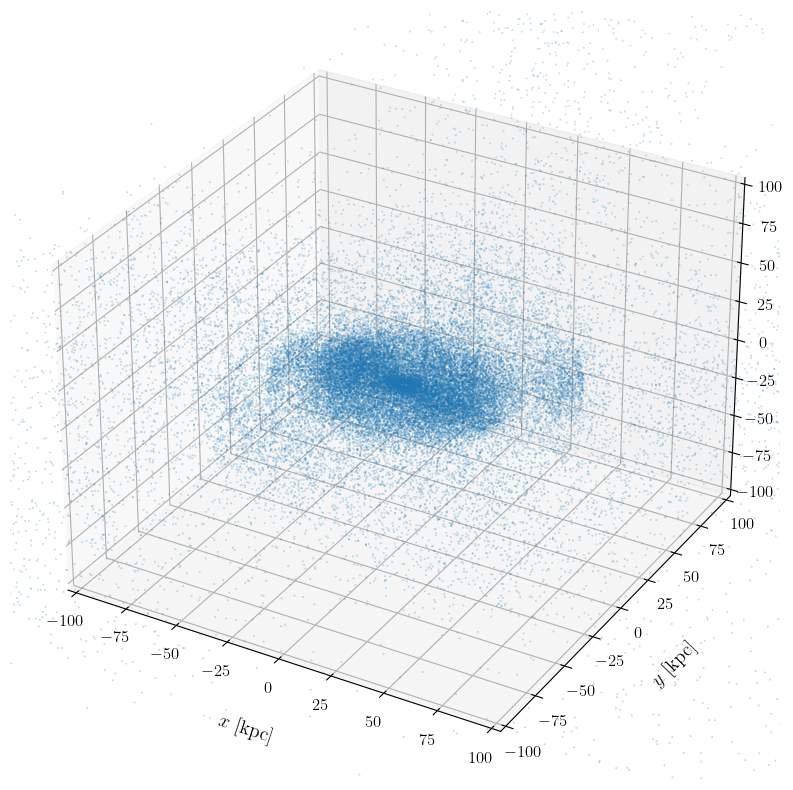

In [65]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z, s=0.1)
ax.set_xlabel(r'$x$ [kpc]', labelpad=15)
ax.set_ylabel(r'$y$ [kpc]', labelpad=15)
ax.set_zlabel(r'$z$ [kpc]', labelpad=15)
ax.set_xlim3d(-100, 100)
ax.set_ylim3d(-100, 100)
ax.set_zlim3d(-100, 100)

plt.show()